In [1]:
from pandas_datareader.data import DataReader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from scipy.stats import boxcox
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.stattools import acf, pacf
print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.2.0


In [32]:
class Stock_analysis:
    def __init__(self, ticker, data_source="yahoo" , start = datetime(2000,1,1), split=0.8):
        self.ticker = ticker
        self.data_source = data_source
        self.start = start
        self.split = split
        
    def get_stock_data(self):
        self.stock_row = DataReader(self.ticker, self.data_source, self.start)
        self.stock_row = self.stock_row.sort_values("Date")
        return self.stock_row
    
    def log_data(self, stock_row):
        self.stock_row = stock_row
        self.stock_row_log = np.log(1 + self.stock_row)
        return self.stock_row_log
    
    def standardize_data(self):
        self.sc = StandardScaler()
        return self.sc
    
    def split_data(self, df):
        self.df = df
        self.df_train = self.df.iloc[0:int(len(df)*self.split)]
        self.df_test = self.df.iloc[int(len(df)*self.split):]
        return self.df_train, self.df_test
    
    def Visialization(self, df, title, ylabel):
        self.df = df
        self.title = title
        self.fig = plt.figure(figsize=(8, 4))
        self.fig .suptitle(title)
        self.ax1 = plt.subplot(121)
        self.ax1.set_ylabel(ylabel)
        self.ax1.plot(self.df["Close"])
        self.ax2 = plt.subplot(122)
        self.ax2.set_ylabel("Frequency")
        self.ax2.hist(self.df["Close"])
        plt.tight_layout(rect=[0,0,1,0.96])
        plt.show()
        
    def create_dataset(self, X, y, time_steps=1):
        self.X = X
        self.y = y
        self.Xs, self.ys = [], []
        self.time_steps = time_steps
        for self.i in range(len(self.X) - self.time_steps):
            self.v = self.X.iloc[self.i:(self.i + self.time_steps)].values
            self.Xs.append(self.v)        
            self.ys.append(self.y.iloc[self.i + self.time_steps])
        return np.array(self.Xs), np.array(self.ys)
    
    def Creating_Models(self, timesteps, num_features, hidden = 10):
        self.hidden = hidden
        self.timesteps = timesteps
        self.num_features = num_features
        self.model = Sequential([
            #Encoder
            LSTM(self.hidden, input_shape=(self.timesteps, self.num_features)),
            #Dropout(0.2),
            #Decoder
            RepeatVector(self.timesteps),
            LSTM(self.hidden, return_sequences=True),
            #Dropout(0.2),
            TimeDistributed(Dense(self.num_features))                 
        ])
        return self.model
    
    def plotting_history(self, history):
        self.history = history
        plt.figure(figsize=(4, 4))
        plt.plot(self.history.history['loss'], label='Training Loss')
        plt.plot(self.history.history['val_loss'], label='Validation Loss')
        plt.xlabel("Epochs")
        plt.ylabel("loss")
        plt.legend()
        plt.show()
        
    def plotting_dist(self, loss, title):
        self.loss = loss
        self.title = title
        plt.figure(figsize=(4, 4))
        sns.distplot(self.loss, bins=50, kde=True, axlabel=self.title)
        plt.show()

    def Visualize_detect_anomaly(self, df, THRESHOLD, title):
        self.df = df
        self.THRESHOLD = THRESHOLD
        self.title = title
        
        plt.figure(figsize=(8, 5))
        plt.suptitle(title)
        plt.subplot(211)
        plt.ylabel("Stock Price(Yen)")
        for self.i in range(len(self.df)):
            if self.df["anomaly"].iat[self.i] == False:
                plt.plot(self.df.index[self.i:self.i+2], self.df["Close"][self.i:self.i+2], c="blue")
            else:
                plt.plot(self.df.index[self.i:self.i+2], self.df["Close"][self.i:self.i+2], c="red")
        plt.subplot(212)
        plt.ylabel("loss")
        for self.i in range(len(self.df)):
            if self.df["anomaly"].iat[self.i] == False:
                plt.plot(self.df.index[self.i:self.i+2], self.df["loss"][self.i:self.i+2], c="blue")
            else:
                plt.plot(self.df.index[self.i:self.i+2], self.df["loss"][self.i:self.i+2], c="red")
        plt.plot([self.df.index[0], self.df.index[-1]], [self.THRESHOLD,self.THRESHOLD], c="green")
        plt.tight_layout(rect=[0,0,1,0.96])
        plt.show()
         
    def main(self):
        self.stock_row = self.get_stock_data()
        self.stock_row_log = self.log_data(self.stock_row)
        self.Visialization(self.stock_row, "Row Stock Price Data", "Stock Price Yen(Close)")
        self.Visialization(self.stock_row_log, "Log Stock Price Data", "Stock Price Log_Yen(Close)")
        
        #split Data
        self.df_train, self.df_test = self.split_data(self.stock_row_log)
        #Standardize Data
        self.sc = self.standardize_data()
        self.df_train_std = self.sc.fit_transform(self.df_train)
        self.df_train_std = pd.DataFrame(self.df_train_std, columns=self.stock_row.columns)
        self.df_test_std = self.sc.transform(self.df_test)
        self.df_test_std = pd.DataFrame(self.df_test_std, columns=self.stock_row.columns)
        #Don't use Volume
        self.X_train, self.y_train = self.create_dataset(self.df_train_std.iloc[: , :4], self.df_train_std.iloc[: , :4], time_steps=30)
        self.X_test, self.y_test = self.create_dataset(self.df_test_std.iloc[: , :4], self.df_test_std.iloc[: , :4], time_steps=30)
        
        self.timesteps = self.X_train.shape[1]
        self.num_features = self.X_train.shape[2]
        
        self.model = self.Creating_Models(self.timesteps, self.num_features, 10)
        self.model.compile(loss='mse', optimizer='adam')
        self.model.summary()
        self.es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')
        self.history = self.model.fit(
            self.X_train, self.X_train,
            epochs=100,
            batch_size=128,
            validation_split=0.1,
            callbacks = [self.es],
            shuffle=False
        )
        
        self.plotting_history(self.history)
        
        print("Model Evaluation:", self.model.evaluate(self.X_test, self.X_test))
        
        self.X_train_pred = self.model.predict(self.X_train)
        self.train_mse_loss =np.mean(np.mean(((self.X_train_pred-self.X_train)**2), axis=1), axis=1)
        self.plotting_dist(self.train_mse_loss, "train_mse_loss")
        
        self.X_test_pred = self.model.predict(self.X_test)
        self.test_mse_loss =np.mean(np.mean(((self.X_test_pred-self.X_test)**2), axis=1), axis=1)
        self.plotting_dist(self.test_mse_loss, "test_mse_loss")
        
        self.THRESHOLD = np.percentile(self.test_mse_loss , 90)

        self.train_score_df = np.exp(self.df_train).iloc[self.time_steps:].copy()
        self.train_score_df['loss'] = self.train_mse_loss.ravel()
        self.train_score_df['threshold'] = self.THRESHOLD
        self.train_score_df['anomaly'] = self.train_score_df.loss > self.train_score_df.threshold
        
        self.test_score_df = np.exp(self.df_test).iloc[self.time_steps:].copy()
        self.test_score_df['loss'] = self.test_mse_loss.ravel()
        self.test_score_df['threshold'] = self.THRESHOLD
        self.test_score_df['anomaly'] = self.test_score_df.loss > self.test_score_df.threshold
        
        self.Visualize_detect_anomaly(self.train_score_df, self.THRESHOLD, "Stock Price&loss({})_train".format(Stock_analysis(ticker=self.ticker, data_source="yahoo").ticker))
        self.Visualize_detect_anomaly(self.test_score_df, self.THRESHOLD,  "Stock Price&loss({})_test".format(Stock_analysis(ticker=self.ticker, data_source="yahoo").ticker))

In [33]:
#timesteps=30, hidden=10

# Nikkei 225(^N225)

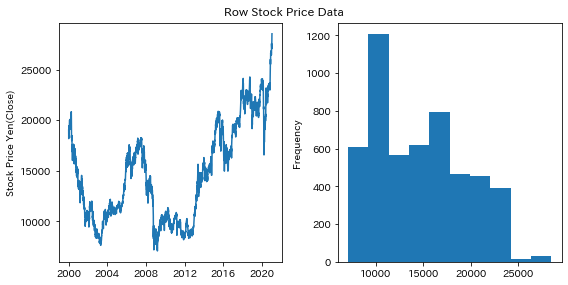

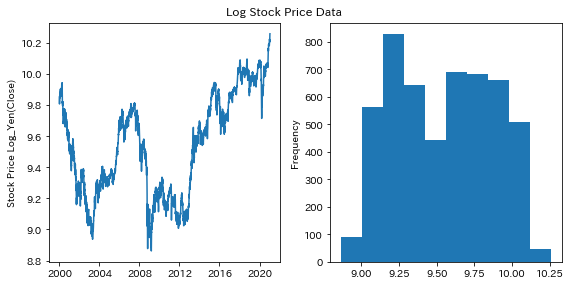

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_28 (LSTM)               (None, 10)                600       
_________________________________________________________________
repeat_vector_14 (RepeatVect (None, 30, 10)            0         
_________________________________________________________________
lstm_29 (LSTM)               (None, 30, 10)            840       
_________________________________________________________________
time_distributed_14 (TimeDis (None, 30, 4)             44        
Total params: 1,484
Trainable params: 1,484
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
29/29 [==============================] - 1s 38ms/step - loss: 0.9354 - val_loss: 1.7477
Epoch 2/100
29/29 [==============================] - 1s 17ms/step - loss: 0.5527 - val_loss: 1.1134
Epoch 3/100
29/29 [==============================

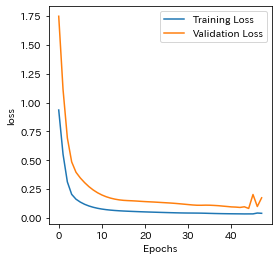

32/32 [==============================] - 0s 3ms/step - loss: 0.7652
Model Evaluation: 0.7651939988136292


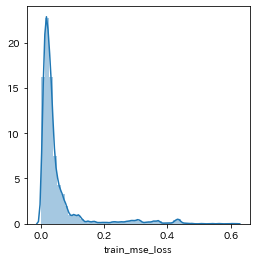

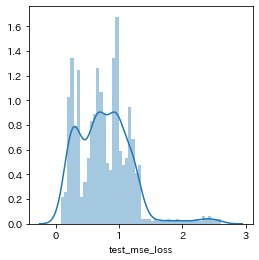

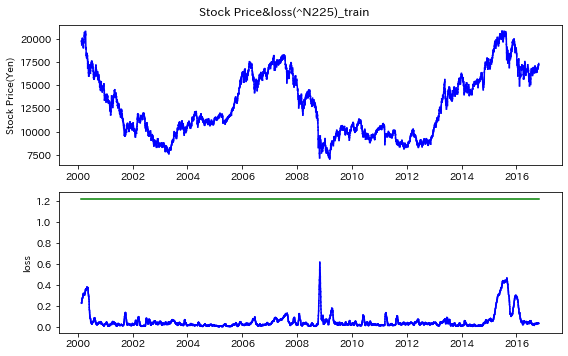

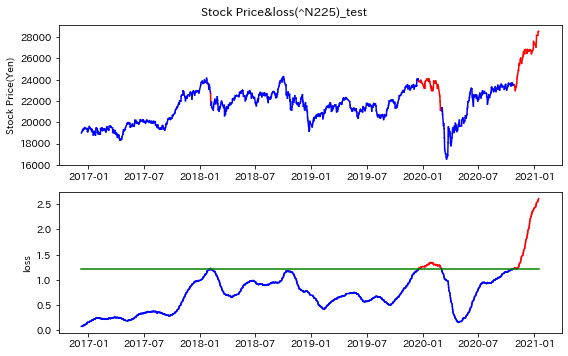

In [34]:
Stock_analysis(ticker="^N225", data_source = "yahoo").main()

# Nippon Steel Corporation(5401.T)

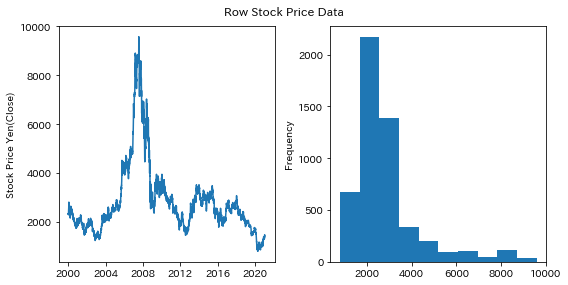

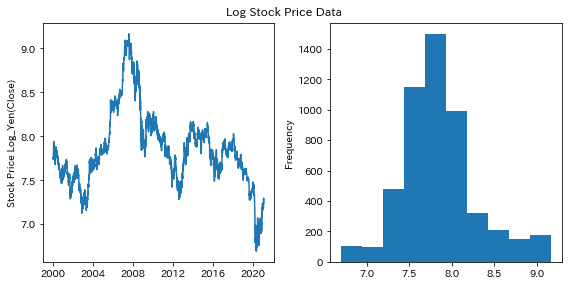

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_30 (LSTM)               (None, 10)                600       
_________________________________________________________________
repeat_vector_15 (RepeatVect (None, 30, 10)            0         
_________________________________________________________________
lstm_31 (LSTM)               (None, 30, 10)            840       
_________________________________________________________________
time_distributed_15 (TimeDis (None, 30, 4)             44        
Total params: 1,484
Trainable params: 1,484
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
29/29 [==============================] - 1s 35ms/step - loss: 0.8120 - val_loss: 0.0911
Epoch 2/100
29/29 [==============================] - 0s 17ms/step - loss: 0.5919 - val_loss: 0.0669
Epoch 3/100
29/29 [==============================

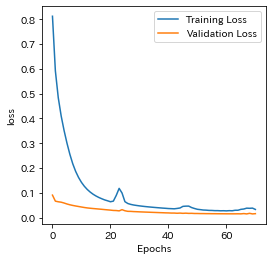

32/32 [==============================] - 0s 4ms/step - loss: 0.1146
Model Evaluation: 0.11463676393032074


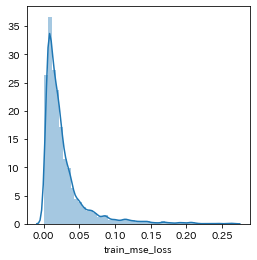

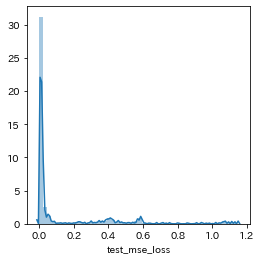

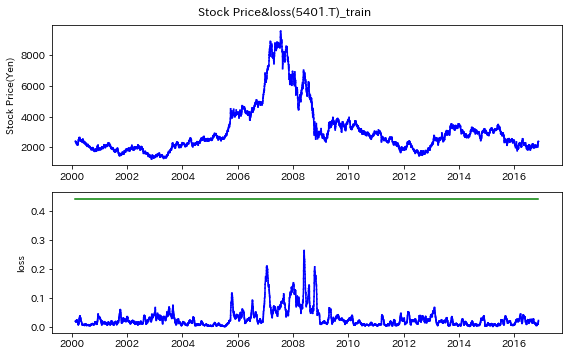

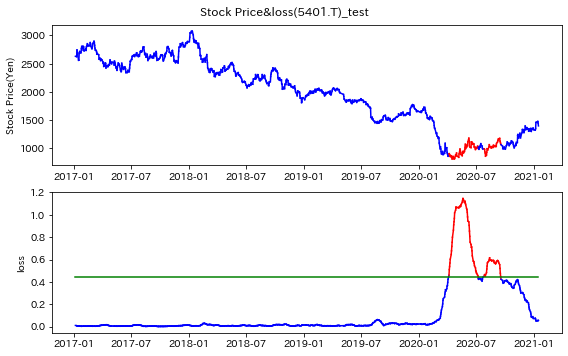

In [35]:
Stock_analysis(ticker="5401.T", data_source = "yahoo").main()

# Toshiba Corporation(6502.T)

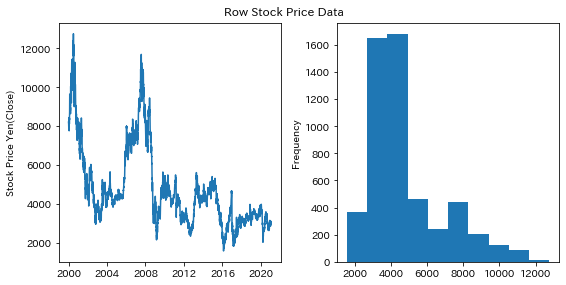

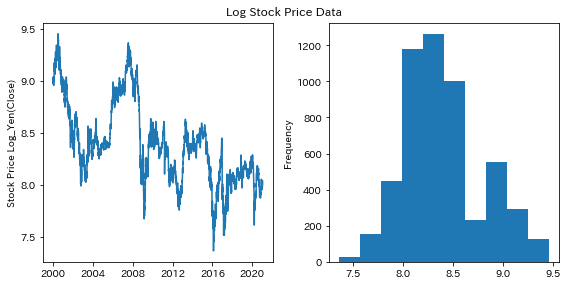

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_32 (LSTM)               (None, 10)                600       
_________________________________________________________________
repeat_vector_16 (RepeatVect (None, 30, 10)            0         
_________________________________________________________________
lstm_33 (LSTM)               (None, 30, 10)            840       
_________________________________________________________________
time_distributed_16 (TimeDis (None, 30, 4)             44        
Total params: 1,484
Trainable params: 1,484
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
30/30 [==============================] - 1s 35ms/step - loss: 1.0467 - val_loss: 1.5987
Epoch 2/100
30/30 [==============================] - 1s 17ms/step - loss: 0.7398 - val_loss: 1.2597
Epoch 3/100
30/30 [==============================

30/30 [==============================] - 1s 18ms/step - loss: 0.0353 - val_loss: 0.1212
Epoch 74/100
30/30 [==============================] - 1s 18ms/step - loss: 0.0312 - val_loss: 0.1190
Epoch 75/100
30/30 [==============================] - 1s 18ms/step - loss: 0.0302 - val_loss: 0.1189
Epoch 76/100
30/30 [==============================] - 1s 18ms/step - loss: 0.0300 - val_loss: 0.1196
Epoch 77/100
30/30 [==============================] - 1s 18ms/step - loss: 0.0301 - val_loss: 0.1182
Epoch 78/100
30/30 [==============================] - 1s 18ms/step - loss: 0.0299 - val_loss: 0.1152
Epoch 79/100
30/30 [==============================] - 1s 18ms/step - loss: 0.0297 - val_loss: 0.1133
Epoch 80/100
30/30 [==============================] - 1s 18ms/step - loss: 0.0299 - val_loss: 0.1153
Epoch 81/100
30/30 [==============================] - 1s 18ms/step - loss: 0.0301 - val_loss: 0.1209
Epoch 82/100
30/30 [==============================] - 1s 18ms/step - loss: 0.0315 - val_loss: 0.1169


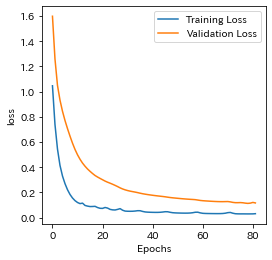

33/33 [==============================] - 0s 3ms/step - loss: 0.0536
Model Evaluation: 0.0536150224506855


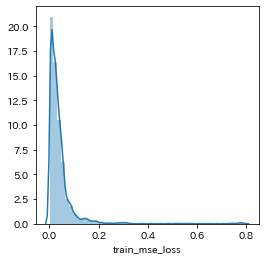

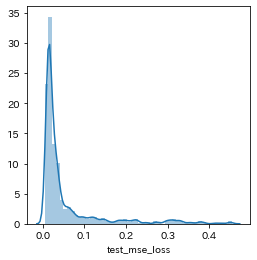

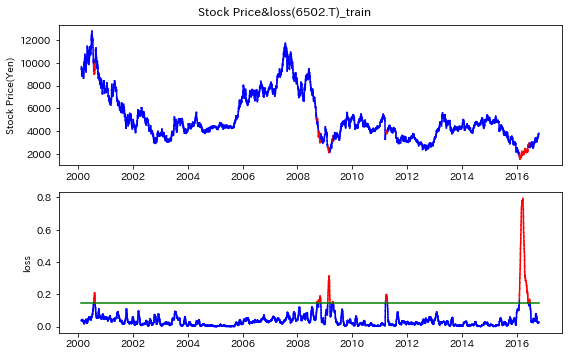

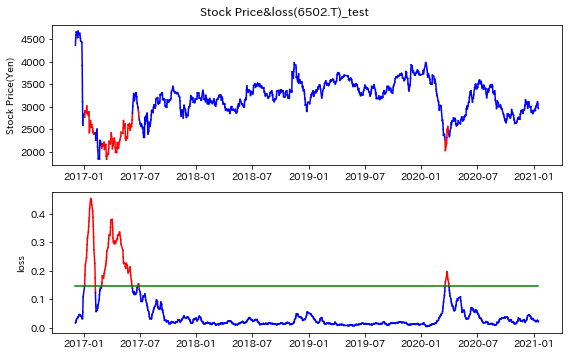

In [36]:
Stock_analysis(ticker="6502.T", data_source = "yahoo").main()

# Mitsubishi Heavy Industries(7011.T)

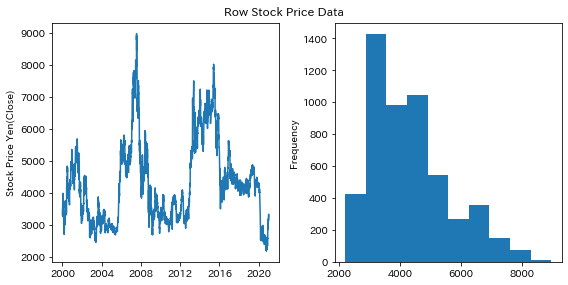

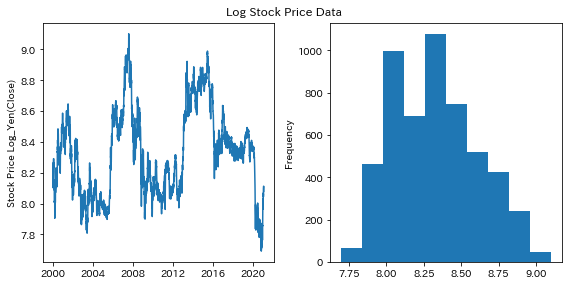

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_34 (LSTM)               (None, 10)                600       
_________________________________________________________________
repeat_vector_17 (RepeatVect (None, 30, 10)            0         
_________________________________________________________________
lstm_35 (LSTM)               (None, 30, 10)            840       
_________________________________________________________________
time_distributed_17 (TimeDis (None, 30, 4)             44        
Total params: 1,484
Trainable params: 1,484
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
30/30 [==============================] - 1s 35ms/step - loss: 0.8499 - val_loss: 1.1778
Epoch 2/100
30/30 [==============================] - 1s 17ms/step - loss: 0.6749 - val_loss: 1.0135
Epoch 3/100
30/30 [==============================

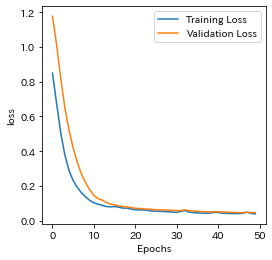

33/33 [==============================] - 0s 3ms/step - loss: 0.0372
Model Evaluation: 0.03719104081392288


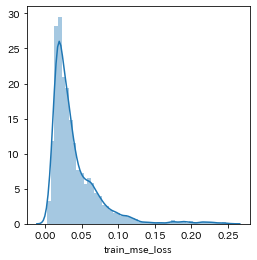

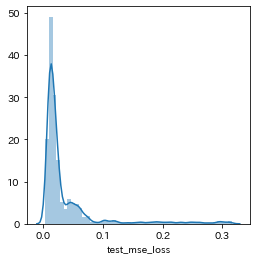

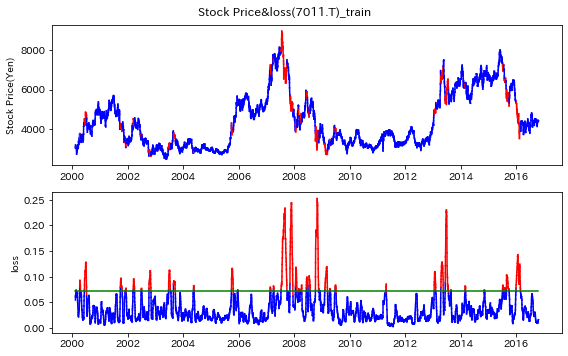

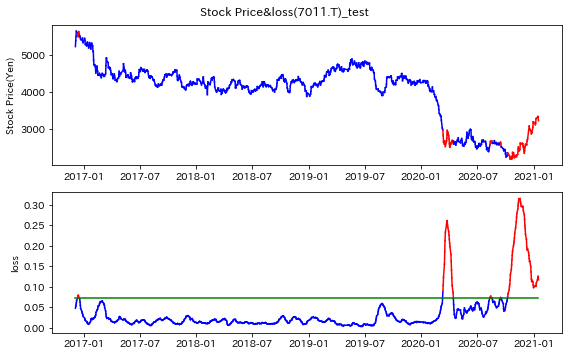

In [37]:
Stock_analysis(ticker="7011.T", data_source = "yahoo").main()

# Sony Corporation(6758.T)

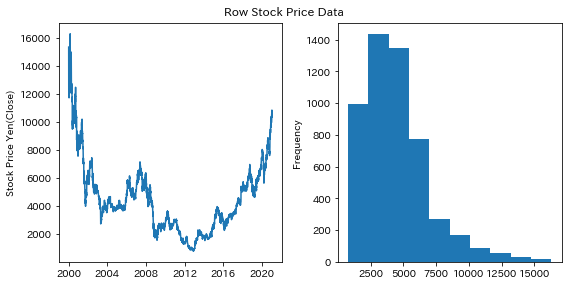

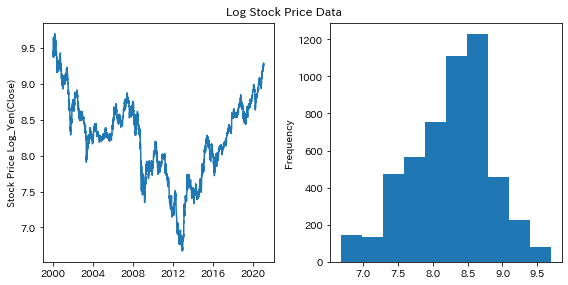

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_36 (LSTM)               (None, 10)                600       
_________________________________________________________________
repeat_vector_18 (RepeatVect (None, 30, 10)            0         
_________________________________________________________________
lstm_37 (LSTM)               (None, 30, 10)            840       
_________________________________________________________________
time_distributed_18 (TimeDis (None, 30, 4)             44        
Total params: 1,484
Trainable params: 1,484
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
29/29 [==============================] - 1s 36ms/step - loss: 0.9682 - val_loss: 0.0457
Epoch 2/100
29/29 [==============================] - 0s 17ms/step - loss: 0.7350 - val_loss: 0.0282
Epoch 3/100
29/29 [==============================

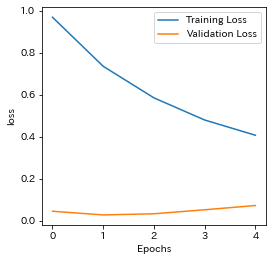

32/32 [==============================] - 0s 3ms/step - loss: 0.2148
Model Evaluation: 0.21483710408210754


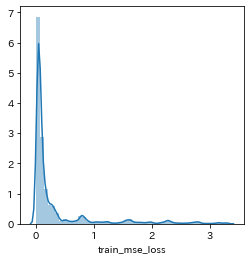

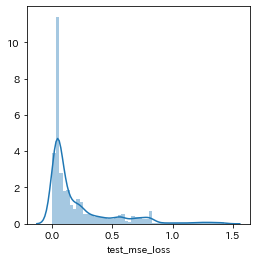

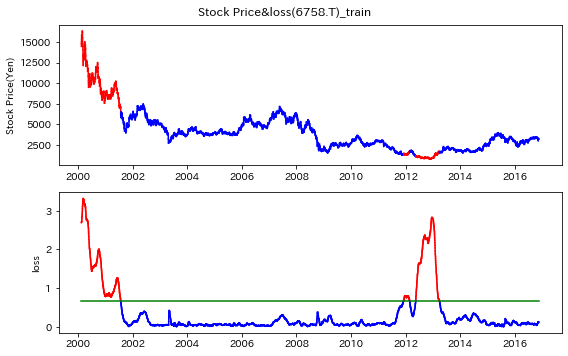

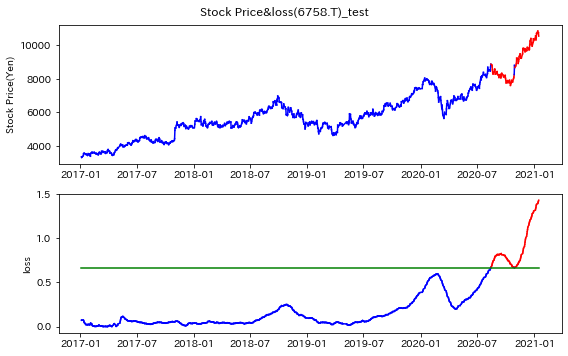

In [38]:
Stock_analysis(ticker="6758.T", data_source = "yahoo").main()

# Nippon Telegraph and Telephone Corporation (9432.T)

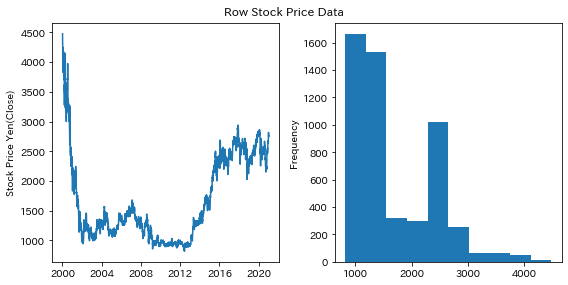

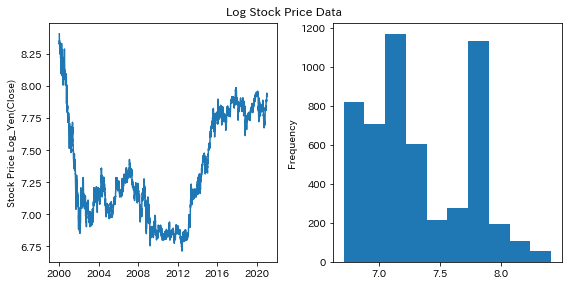

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_38 (LSTM)               (None, 10)                600       
_________________________________________________________________
repeat_vector_19 (RepeatVect (None, 30, 10)            0         
_________________________________________________________________
lstm_39 (LSTM)               (None, 30, 10)            840       
_________________________________________________________________
time_distributed_19 (TimeDis (None, 30, 4)             44        
Total params: 1,484
Trainable params: 1,484
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
30/30 [==============================] - 1s 36ms/step - loss: 0.7251 - val_loss: 1.5707
Epoch 2/100
30/30 [==============================] - 1s 17ms/step - loss: 0.5700 - val_loss: 1.2274
Epoch 3/100
30/30 [==============================

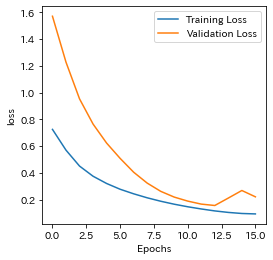

33/33 [==============================] - 0s 3ms/step - loss: 0.2268
Model Evaluation: 0.22684210538864136


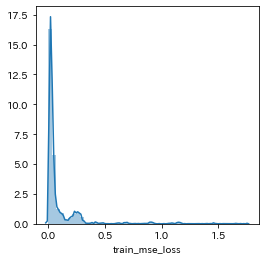

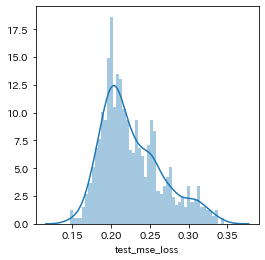

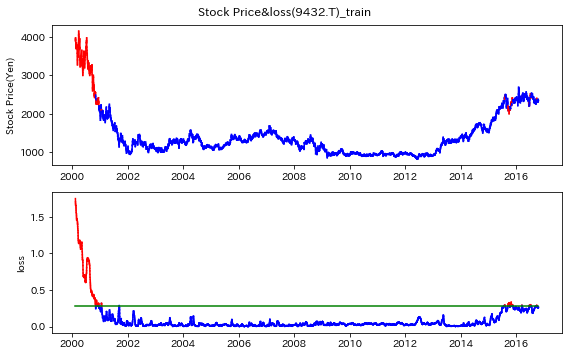

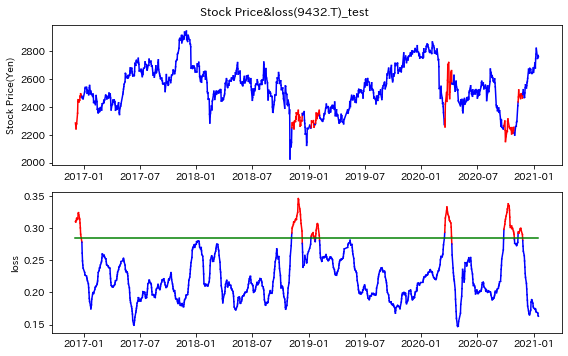

In [39]:
Stock_analysis(ticker="9432.T", data_source = "yahoo").main()

# Canon(7751.T)

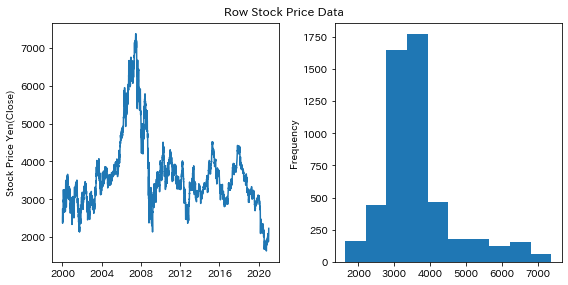

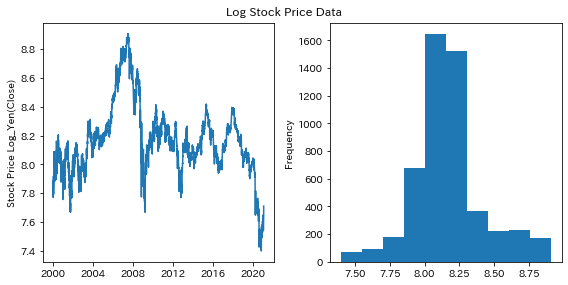

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_40 (LSTM)               (None, 10)                600       
_________________________________________________________________
repeat_vector_20 (RepeatVect (None, 30, 10)            0         
_________________________________________________________________
lstm_41 (LSTM)               (None, 30, 10)            840       
_________________________________________________________________
time_distributed_20 (TimeDis (None, 30, 4)             44        
Total params: 1,484
Trainable params: 1,484
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
29/29 [==============================] - 1s 37ms/step - loss: 1.0380 - val_loss: 0.2538
Epoch 2/100
29/29 [==============================] - 0s 17ms/step - loss: 0.8465 - val_loss: 0.1755
Epoch 3/100
29/29 [==============================

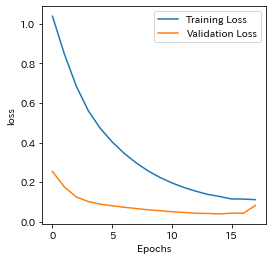

32/32 [==============================] - 0s 3ms/step - loss: 0.4709
Model Evaluation: 0.47091802954673767


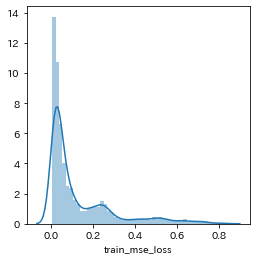

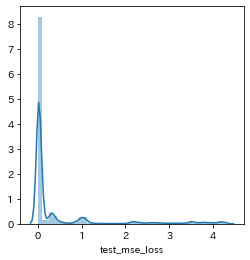

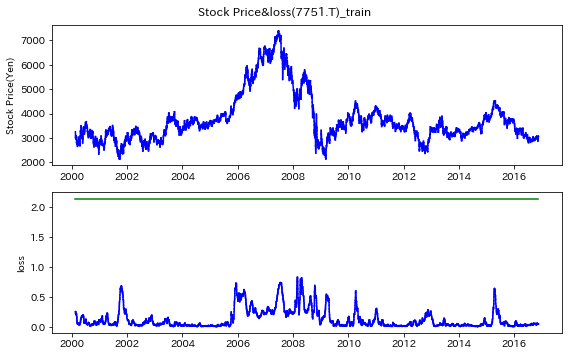

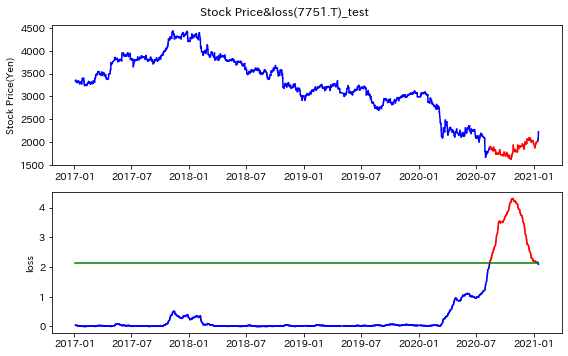

In [40]:
Stock_analysis(ticker="7751.T", data_source = "yahoo").main()

# Bridgestone Corporation (5108.T)

In [ ]:
Stock_analysis(ticker="5108.T", data_source = "yahoo").main()

# Marubeni Corporation (8002.T)

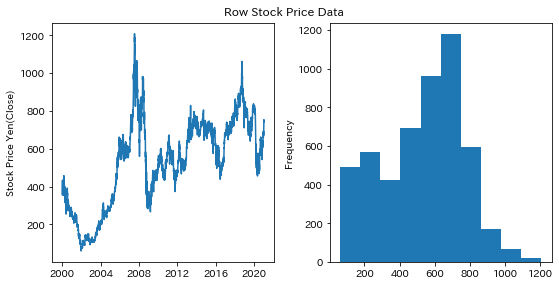

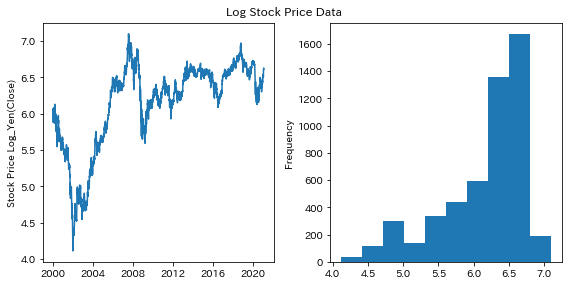

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_42 (LSTM)               (None, 10)                600       
_________________________________________________________________
repeat_vector_21 (RepeatVect (None, 30, 10)            0         
_________________________________________________________________
lstm_43 (LSTM)               (None, 30, 10)            840       
_________________________________________________________________
time_distributed_21 (TimeDis (None, 30, 4)             44        
Total params: 1,484
Trainable params: 1,484
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
29/29 [==============================] - 1s 37ms/step - loss: 1.1557 - val_loss: 0.4500
Epoch 2/100
29/29 [==============================] - 1s 18ms/step - loss: 0.8947 - val_loss: 0.2834
Epoch 3/100
29/29 [==============================

29/29 [==============================] - 1s 18ms/step - loss: 0.0261 - val_loss: 0.0087
Epoch 74/100
29/29 [==============================] - 1s 18ms/step - loss: 0.0293 - val_loss: 0.0078
Epoch 75/100
29/29 [==============================] - 1s 18ms/step - loss: 0.0283 - val_loss: 0.0095
Epoch 76/100
29/29 [==============================] - 1s 18ms/step - loss: 0.0329 - val_loss: 0.0092
Epoch 77/100
29/29 [==============================] - 1s 18ms/step - loss: 0.0265 - val_loss: 0.0081


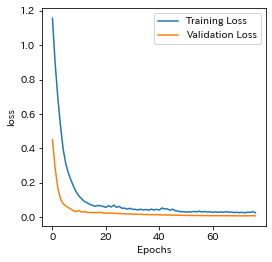

32/32 [==============================] - 0s 3ms/step - loss: 0.0131
Model Evaluation: 0.013120565563440323


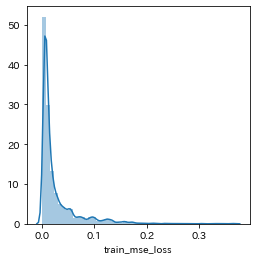

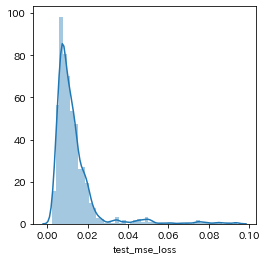

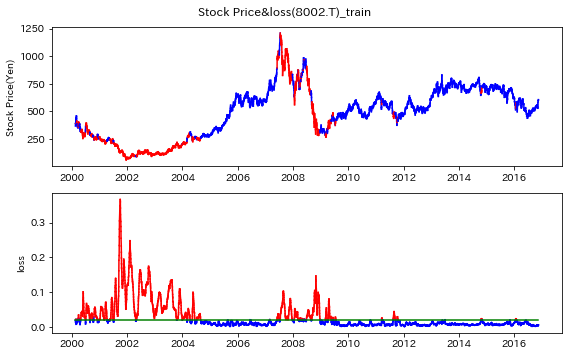

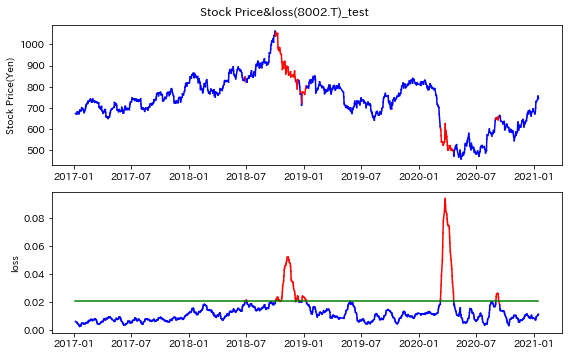

In [41]:
Stock_analysis(ticker="8002.T", data_source = "yahoo").main()